<a href="https://colab.research.google.com/github/rtajeong/AI_Cluster_ASAT/blob/main/3_Wafer_Classification_Augmentation_ASAT_rev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Reference site:
  - https://www.kaggle.com/code/kcs93023/keras-wafer-classification-cnn2d-with-augmentation/notebook
  - https://www.kaggle.com/code/ashishpatel26/wm-811k-wafermap

## Introduction

811,457 wafer maps collected from 46,393 lots in real-world fabrication

Here lists all defects type in this dataset:

- Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none.

- ref paper: Wu, Ming-Ju, Jyh-Shing R. Jang, and Jui-Long Chen. “Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets.” IEEE Transactions on Semiconductor Manufacturing 28, no. 1 (February 2015): 1–12.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

- 데이터 사이즈가 커서 매번 다운 받지 않고 구글 드라이버에 저장해 놓고 마운트해서 직접 엑세스하기로 한다.

In [ ]:
# data is stored in
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l drive/MyDrive/Data/Semicon_Wafer/WM811K.pkl

-rw------- 1 root root 2022961642 Apr 18  2022 drive/MyDrive/Data/Semicon_Wafer/WM811K.pkl


# 데이터 엑세스

In [ ]:
file = 'drive/MyDrive/Data/Semicon_Wafer/WM811K.pkl'  # too big
df = pd.read_pickle(file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- 데이터 세트는 811,457개의 웨이퍼 맵과 웨이퍼 다이 크기, 로트 이름 및 웨이퍼 인덱스, 그리고 결함 유형의 정보로 구성되어 있다.
- 훈련/테스트 세트는 이미 도메인 전문가에 의해 분할되었지만, 여기서는 이 정보를 무시하고 데이터 세트를 직접 훈련 세트와 테스트 세트로 다시 분할해서 사용하기로 한다.

- 결함 유형(failureType)은 주로 아래와 같은 패턴으로 구분된다.
  - Center: 웨이퍼 중앙에 집중된 결함.
  - Edge-Loc: 웨이퍼 가장자리 근처에 결함이 발생.
  - Edge-Ring: 웨이퍼 주변에 고리 모양으로 결함이 나타남.
  - Loc: 특정 지역에 국한된 결함.
  - Random: 임의의 위치에 발생한 결함.
  - Scratch: 긁힘이나 선형 결함.
  - Donut: 도넛 모양의 결함 패턴.
  - None : 결함이 없는 웨이퍼.
  - [0, 0]: 원 논문에서는 이에 대한 언급이 없지만 대부분 결함이 없는 것으로 간주하는 게 보통이다. 데이터 처리를 위해 해쉬가 가능한 Tuple, 즉 (0,0) 의 형태로 변환해서 사용하는 게 편리하다.

- Lot: 반도체 제조에서 "lot"(또는 "생산 배치")는 반도체 칩을 생산하는 과정에서 하나의 생산 단위를 의미한다. 좀 더 구체적으로, 여러 개의 웨이퍼가 동시에 하나의 공정을 거치는 단위를 "lot"이라고 한다. 각 lot은 일련의 동일한 제조 공정을 거치며, 생산 추적 및 관리의 기본 단위로 사용된다.

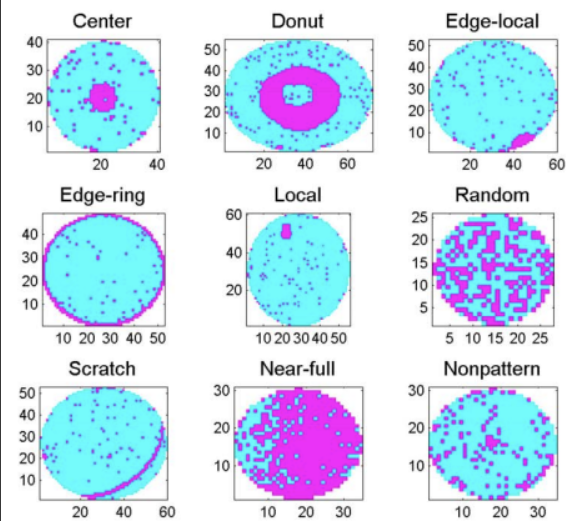

In [ ]:
pd.concat([df.head(3), df.tail(3)])

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
811454,600.0,Edge-Ring,lot47542,Test,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,"[0, 0]",lot47543,"[0, 0]",1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."
811456,600.0,"[0, 0]",lot47543,"[0, 0]",2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."


- 데이터 세트는 실제 팹의 47,543개 로트에서 수집되어 47,543개 로트 x 25개 웨이퍼/로트 = 1,157,325개 웨이퍼 맵이 되어야 하지만 실제로는 811,457개 웨이퍼 맵이 있다. 이유는 아래 그래프에서 보듯이 모든 로트가 완벽한 25 웨이퍼 맵을 가지고 있지는 않으며, 센서 오류 또는 기타 알려지지 않은 문제로 인해 발생할 수 있음을 보여준다.
- 결함 종류를 분류하는 데 있어 웨이퍼 인덱스는 사용하지 않을 것이기 때문에 큰 문제가 되지 않는다.

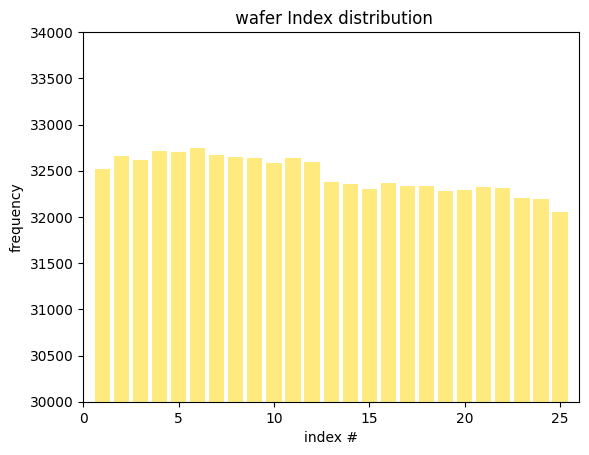

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [ ]:
df = df.drop(['waferIndex'], axis = 1)

- 웨이퍼 맵 열에서 많은 정보를 얻을 수는 없지만 각 인스턴스의 다이 크기가 다르다는 것을 알 수 있다.
- 웨이퍼 맵 dimension 검사를 위해 새 변수 'waferMapDim'을 만든다. 웨이퍼 dimension 은 웨이퍼 맵의 크기를 차원 측면에서 나타낸 것으로 일반적으로 웨이퍼를 나타내는 그리드의 행과 열의 수이다.


In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)  # number of elements
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,waferMapDim
702000,516.0,none,lot43104,Training,22.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,...","(25, 27)"
403143,811.0,"[0, 0]",lot24146,"[0, 0]",12.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...","(34, 31)"
216971,2003.0,"[0, 0]",lot13761,"[0, 0]",21.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(51, 50)"
94529,3695.0,"[0, 0]",lot6671,"[0, 0]",3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(62, 76)"
377048,2126.0,Edge-Ring,lot22471,Training,16.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 52)"


In [ ]:
df['waferMapDim'].value_counts()[:15]

,count
waferMapDim,
"(32, 29)",108687
"(25, 27)",64083
"(49, 39)",39323
"(26, 26)",30078
"(30, 34)",29513
"(33, 33)",23886
"(33, 29)",20276
"(39, 37)",15327
"(52, 59)",14812


# 데이터 이해
- 웨이퍼 맵의 크기가 너무 크므로 이 중 특정 dimension 의 웨이퍼 맵을 선택한다. 가능하면 여러 형태의 결함이 다양하게 나타난 dimension 을 선택하기 위해 각 dimension 의 웨이퍼 맵들이 여러 형태의 결함들을 얼마나 가지고 있는지 보기 위해 아래와 같은 검사를 실행한다.

In [ ]:
# df['filureType'] 에 array가 들어 있어 hashing 이 안되어 실행이 안된다.
# hashable 하게 만들어 주어야 한다. (immutable type 이 주로 hashable)

def make_hashable(x):
    """Converts NumPy arrays and lists to tuples to make them hashable."""
    if isinstance(x, (np.ndarray, list)):
        return tuple(x)
    return x

# Apply the function to the 'failureType' column
df['failureType'] = df['failureType'].apply(make_hashable)

# Now you should be able to call unique() without the error
ftypes = df['failureType'].unique()
ftypes

array(['none', 'Loc', (0, 0), 'Edge-Loc', 'Center', 'Edge-Ring',
       'Scratch', 'Random', 'Near-full', 'Donut'], dtype=object)

In [ ]:
# 여러가지 형태의 웨이퍼 맵 종류 (상위 15 가지)
df['waferMapDim'].value_counts()[:15].index

Index([(32, 29), (25, 27), (49, 39), (26, 26), (30, 34), (33, 33), (33, 29),
       (39, 37), (52, 59), (31, 31), (39, 31), (29, 26), (27, 25), (64, 71),
       (31, 28)],
      dtype='object', name='waferMapDim')

In [ ]:
# 전체 웨이퍼 맵 갯수와 결함 종류 및 갯수

print(f'The total number of wafer samples is {len(df)}')
for f in ftypes:
    if isinstance(f, tuple):
        continue
    y = df['failureType'].values
    print(f'Fault type({f:>10}): {len(y[y==f])}')
print(f'The rest of them are all of type (0,0).')

The total number of wafer samples is 811457
Fault type(      none): 147431
Fault type(       Loc): 3593
Fault type(  Edge-Loc): 5189
Fault type(    Center): 4294
Fault type( Edge-Ring): 9680
Fault type(   Scratch): 1193
Fault type(    Random): 866
Fault type( Near-full): 149
Fault type(     Donut): 555
The rest of them are all of type (0,0).


- None'은 웨이퍼가 특정 실패 패턴을 나타내지 않음을 나타내는 데 사용된다. 이는 분석 방법에 따라 결함이 없는 것으로 분류되거나 식별 가능한 실패 패턴이 없는 웨이퍼를 나타낸다. 이러한 웨이퍼는 여전히 노이즈나 사소한 불일치가 있을 수 있지만, 중요한 실패 패턴은 감지되지 않은 것으로 간주한다.
- [0,0]의 경우, 원 논문은 이 표기법을 명시적으로 정의하지 않았지만, 실패 패턴이 없거나 관심 없는 영역으로 분류된 웨이퍼 맵에 해당하는 것으로 보인다. 일반적으로 이는 상당한 활동이 없거나 결함이 감지되지 않은 웨이퍼 영역을 나타낼 수 있으며, 웨이퍼 맵에서 일반적으로 사용되는 방식을 기준으로, 이는 결함이 없는 영역을 나타낼 수 있다.

- 'none' 타입과 '(0,0) 타입의 비교를 위해 다음을 확인한다.

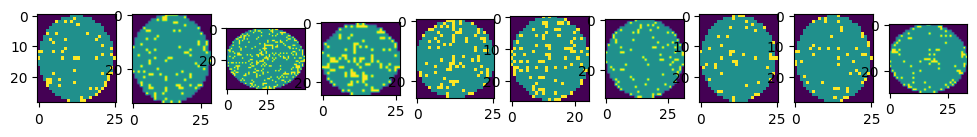

In [ ]:
# 'none' type
np.random.seed(42)
id_tuple = np.random.choice(df[df['failureType'] == 'none'].index, size=10, replace=False)

# plot 10 samples of fault type (0,0)
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(12,4))
ax = ax.ravel()

for i, idx in enumerate(id_tuple):
    ax[i].imshow(df.loc[idx].waferMap)

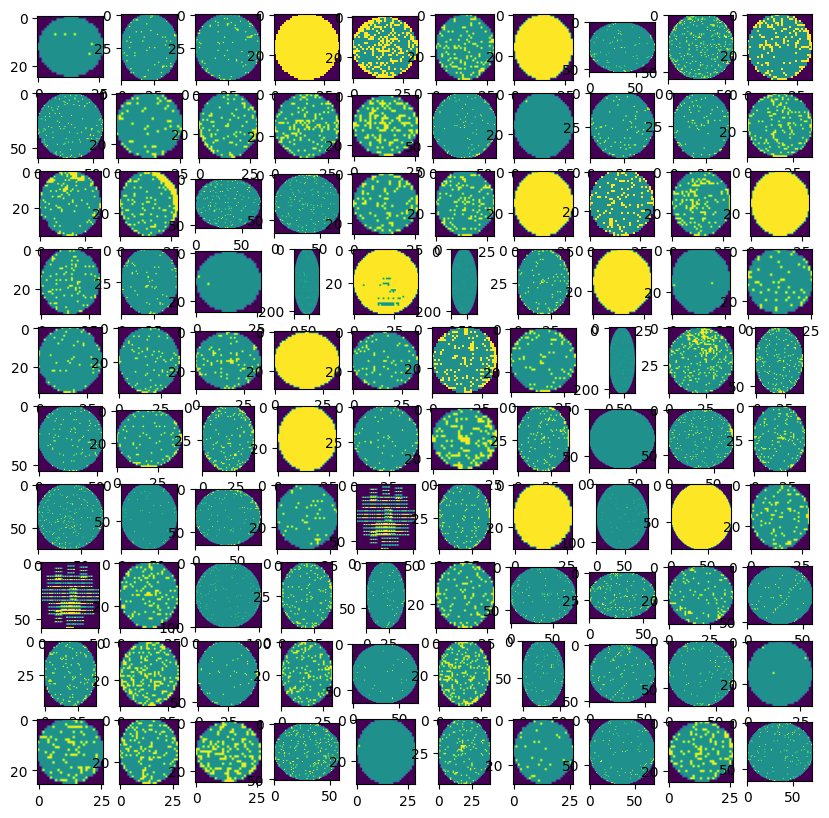

In [ ]:
# (0,0) type
# np.random.seed(42)
id_tuple = np.random.choice(df[df['failureType'] == (0,0)].index, size=100, replace=False)

# plot 100 samples of fault type (0,0)
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))
ax = ax.ravel()

for i, idx in enumerate(id_tuple):
    ax[i].imshow(df.loc[idx].waferMap)

- 'near-full' 에 가까운 패턴들이 들어 있어 모두를 'none' 으로 간주하기는 어려울 것으로 보인다. (mislabel 된 경우도 있을 것임)
- 따라서, (0,0)으로 labele 된 데이터는 훈련용으로 사용하지 않는 게 좋을 것으로 보인다. 그리고 이미 'none' 타입의 데이터는 충분히 많이 있다.

- 각 웨이퍼 dimension 별로 결함 종류별 데이터를 보기 위한 DataFrame 을 구성한다.

In [ ]:
from collections import Counter

dict_list = []
wafer_dims_15 = df['waferMapDim'].value_counts()[:15].index

for dim in wafer_dims_15:
    sub_df = df.loc[df['waferMapDim'] == dim]
    y = sub_df['failureType'].values
    ftype_counts = dict(Counter(y))
    dict_list.append(ftype_counts)

dim_ftype_df = pd.DataFrame(dict_list, index=wafer_dims_15)
dim_ftype_df

,"(0, 0)",Edge-Loc,Loc,Random,Edge-Ring,Donut,Scratch,Center,none,Near-full
waferMapDim,,,,,,,,,,
"(32, 29)",108274,190,90,32.0,44.0,6.0,12,39,NaN,NaN
"(25, 27)",45302,355,172,53.0,25.0,NaN,23,2251,15881.0,21.0
"(49, 39)",39157,56,26,1.0,47.0,5.0,28,3,NaN,NaN
"(26, 26)",15712,296,297,74.0,31.0,1.0,72,90,13489.0,16.0
"(30, 34)",17113,306,241,18.0,9.0,4.0,69,58,11690.0,5.0
"(33, 33)",23655,132,41,8.0,32.0,2.0,3,13,NaN,NaN
"(33, 29)",12151,130,107,12.0,55.0,2.0,47,20,7724.0,28.0
"(39, 37)",5154,473,222,35.0,15.0,22.0,60,173,9158.0,15.0
"(52, 59)",14626,42,57,NaN,NaN,NaN,54,33,NaN,NaN


In [ ]:
dim_ftype_df.dropna()

,"(0, 0)",Edge-Loc,Loc,Random,Edge-Ring,Donut,Scratch,Center,none,Near-full
waferMapDim,,,,,,,,,,
"(26, 26)",15712,296,297,74.0,31.0,1.0,72,90,13489.0,16.0
"(30, 34)",17113,306,241,18.0,9.0,4.0,69,58,11690.0,5.0
"(33, 29)",12151,130,107,12.0,55.0,2.0,47,20,7724.0,28.0
"(39, 37)",5154,473,222,35.0,15.0,22.0,60,173,9158.0,15.0
"(29, 26)",1496,233,117,4.0,64.0,2.0,80,50,11196.0,5.0


# 대상 웨이퍼 타입 선정
- 대상 웨이퍼 맵을 선정하기 위해 (1) 결함 형태가 어느 하나라도 빠진 게 없고, (2) 가능한 한 여러 형태의 결함이 다양하게 나타나 있도록 한다.
- 따라서, Wafermap Dimension (39,37) 을 선택하도록 한다.

In [ ]:
df.loc[df['waferMapDim'] == (39, 37)]['failureType'].value_counts()

,count
failureType,
none,9158
"(0, 0)",5154
Edge-Loc,473
Loc,222
Center,173
Scratch,60
Random,35
Donut,22
Edge-Ring,15


In [ ]:
sub_df = df.loc[df['waferMapDim'] == (39, 37)]
sub_wafer = sub_df['waferMap'].values
sub_df.shape, sub_wafer.shape

((15327, 7), (15327,))

In [ ]:
pd.concat([sub_df.head(3), sub_df.tail(3)])

,dieSize,failureType,lotName,trainTestLabel,waferMap,waferMapDim
67656,1129.0,"(0, 0)",lot5129,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(39, 37)"
67657,1129.0,"(0, 0)",lot5129,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(39, 37)"
67658,1129.0,"(0, 0)",lot5129,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(39, 37)"
763744,1109.0,none,lot45599,Test,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...","(39, 37)"
763745,1109.0,"(0, 0)",lot45600,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...","(39, 37)"
763746,1109.0,"(0, 0)",lot45600,"[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...","(39, 37)"


In [ ]:
sub_df.isnull().sum().sum()  # no missing values

0

In [ ]:
sub_wafer.shape, sub_wafer[0].shape

((15327,), (39, 37))

In [ ]:
sub_df['failureType'].dtypes, sub_df['failureType'].iloc[:5]

(dtype('O'),
 67656    (0, 0)
 67657    (0, 0)
 67658    (0, 0)
 67659    (0, 0)
 67660    (0, 0)
 Name: failureType, dtype: object)

- 결함 종류 (0,0) 은 데이터에서 제거하기로 한다.

In [ ]:
sub_df = sub_df.drop(sub_df[sub_df['failureType'] == (0,0)].index)

In [ ]:
sub_df['failureType'].value_counts()

,count
failureType,
none,9158
Edge-Loc,473
Loc,222
Center,173
Scratch,60
Random,35
Donut,22
Edge-Ring,15
Near-full,15


- failureType (0,0) 이 제거되었음을 확인하였다.

In [ ]:
# 'failureType'에서 array [0, 0] 값을 모두 "none"으로 변경
# sub_df.loc[:,'failureType'] = sub_df.loc[:,'failureType'].apply(
#          lambda x: 'none' if isinstance(x, tuple) else x)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
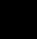

In [ ]:
sub_df['waferMap'].values[0]

- 어떤 모양의 failure 인지 확인

In [ ]:
sub_df['failureType'].unique()

array(['Donut', 'Edge-Loc', 'Loc', 'Scratch', 'Center', 'Random', 'none',
       'Edge-Ring', 'Near-full'], dtype=object)

In [ ]:
# find indices for each filure type

ftype_indices = {}

for type in sub_df['failureType'].unique():
    indices = sub_df[sub_df['failureType'] == type].index
    ftype_indices[type] = indices

print(ftype_indices)

{'Donut': Index([ 68390,  68391,  68415,  68416, 691489, 758427, 761154, 762905, 762914,
       762960, 762985, 762997, 763042, 763172, 763219, 763366, 763367, 763490,
       763505, 763569, 763664, 763695],
      dtype='int64'), 'Edge-Loc': Index([ 68488,  68513,  68873,  68875,  68884,  68885,  68888,  68890,  68898,
        68900,
       ...
       763023, 763028, 763043, 763053, 763107, 763347, 763477, 763523, 763635,
       763685],
      dtype='int64', length=473), 'Loc': Index([ 68782,  68807,  76964,  77194,  77210,  77219,  77225, 110242, 110259,
       110267,
       ...
       763585, 763592, 763622, 763642, 763663, 763666, 763670, 763686, 763708,
       763722],
      dtype='int64', length=222), 'Scratch': Index([ 77141,  77166, 689874, 689917, 689975, 690420, 690473, 690608, 690675,
       690690, 690719, 691013, 691127, 691138, 691433, 691649, 691963, 692051,
       692265, 692304, 692497, 692580, 692764, 692770, 692891, 692923, 692938,
       756812, 756927, 757047, 7570

In [ ]:
ftype_indices.keys()

dict_keys(['Donut', 'Edge-Loc', 'Loc', 'Scratch', 'Center', 'Random', 'none', 'Edge-Ring', 'Near-full'])

# 각 유형별 결함 패턴 확인

- 각 결함 유형에 대해 10 개씩의 데이터를 그려보자

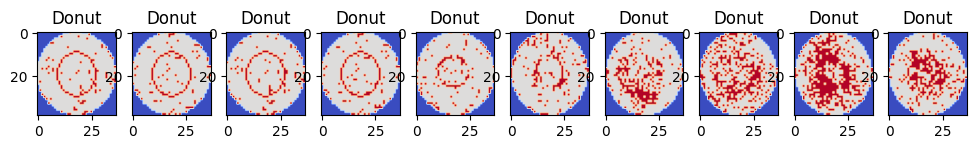

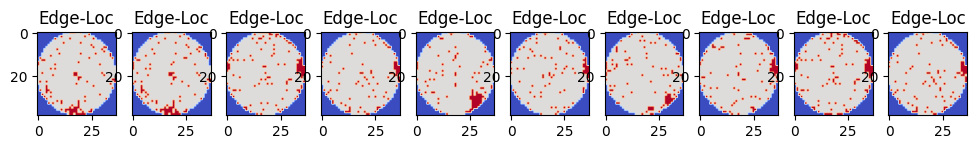

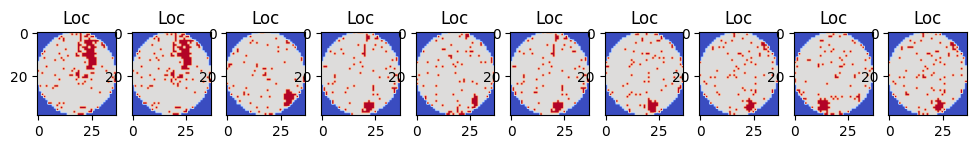

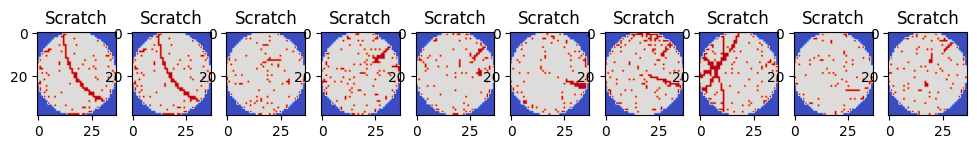

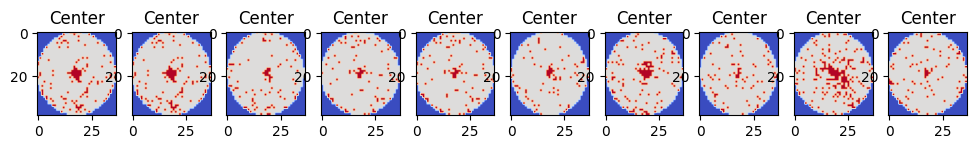

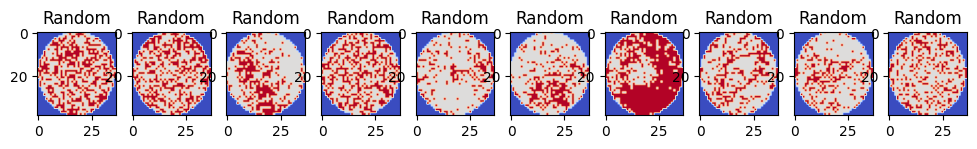

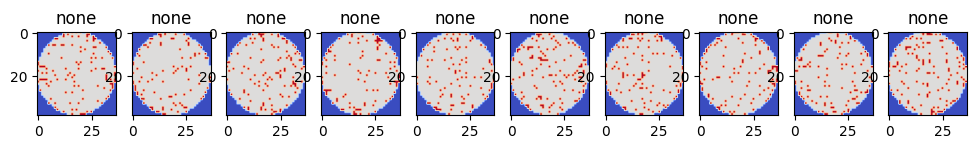

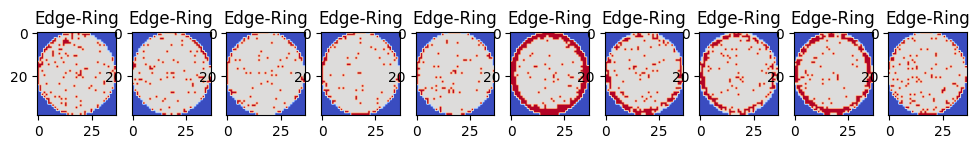

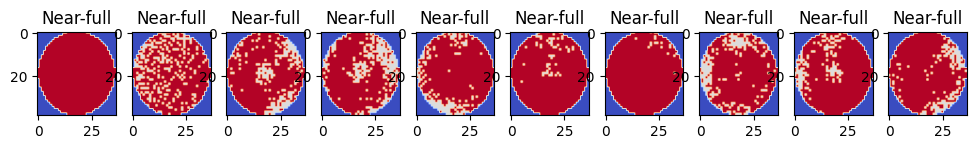

In [ ]:
ftypes = list(ftype_indices.keys())

for k in ftypes:

    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(12, 4))
    ax = ax.ravel()

    for j in range(10):
        idx = ftype_indices[k][j]
        arr = sub_df.loc[idx].waferMap
        ax[j].imshow(arr.reshape(39,37,1), cmap='coolwarm')
        ax[j].set_title(k)

# 웨이퍼 및 결함 유형 데이터 추출

- 해상도 (39, 37) 의 웨이퍼 를 웨이퍼 맵과 결함 유형을 기준으로 array 로 정렬한다. 일부 웨이퍼에 null 레이블이 있으면 건너뛴다.

In [ ]:
from tqdm import tqdm

wafer = np.ones((1, 39, 37))
label = list()

for i in tqdm(range(len(sub_df))):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        print("null length failureType found.")
        continue
    wafer = np.concatenate((wafer, sub_df.iloc[i,:]['waferMap'].reshape(1, 39, 37)))
    label.append(sub_df.iloc[i,:]['failureType'])

wafer = wafer[1:]     # wafer has one null entry (the first entry)

100%|██████████| 10173/10173 [01:55<00:00, 88.10it/s]


In [ ]:
wafer.shape, np.shape(label)

((10173, 39, 37), (10173,))

- 시간이 많이 걸리는 코드이므로 처리된 어레이를 저장해 두고, 필요할 경우 다시 불러 와 사용하면 된다.

In [ ]:
# save the arrays (store the array (faster than pickle)): np.save() and np.load()

# np.save('wafer_transformed', wafer)
# np.save('label_transformed', np.array(label))


In [ ]:
# restore the arrays when needed
# wafer = np.load('drive/MyDrive/Power_semiconductor_cluster/wafer_transformed.npy')
# label = np.load('drive/MyDrive/Power_semiconductor_cluster/label_transformed.npy')

# X-y assignment

In [ ]:
# extend dimension for channel (to use 2D convolutional anutoencoder)
X = wafer[:].reshape(-1, 39, 37, 1)   # add channel
y = np.array(label).reshape((-1,1))

In [ ]:
X.shape, y.shape

((10173, 39, 37, 1), (10173, 1))


Make faulty case list, and check how classes are imbalanced.

In [ ]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

for f in faulty_case :
    print('{:10} : {}'.format(f, len(y[y==f])))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
Center     : 173
Donut      : 22
Edge-Loc   : 473
Edge-Ring  : 15
Loc        : 222
Near-full  : 15
Random     : 35
Scratch    : 60
none       : 9158


In [ ]:
# for your reference
arr_2d = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
arr_y = np.array([11,22,33]).reshape(-1,1)
# Find indices where elements are greater than 5
print(arr_2d, arr_y)
indices = np.where(arr_y == 33)
print(indices[0])

[[1 2 3]
 [4 5 6]
 [7 8 9]] [[11]
 [22]
 [33]]
[2]


- 각 결함 종류의 어레이 인덱스 첫 10 개

In [ ]:
for f in faulty_case :
    indices = np.where(y == f)
    print (f'{f:>10}: {indices[0][:10]}')

    Center: [ 48  49  60  62  63  65  66  67 358 465]
     Donut: [   0    1    2    3 1593 5004 7645 9358 9367 9413]
  Edge-Loc: [ 4  5  8  9 10 11 12 13 14 15]
 Edge-Ring: [ 579 1049 1056 1235 1258 1952 2187 2239 2337 2391]
       Loc: [ 6  7 23 31 35 38 39 50 53 55]
 Near-full: [5623 5982 9381 9423 9440 9511 9535 9536 9548 9570]
    Random: [  61   68  122  219 1570 1858 3016 3178 3422 3941]
   Scratch: [ 25  26 135 178 236 612 643 778 845 860]
      none: [69 70 71 72 73 74 75 76 77 78]


# 데이터 One-Hot Encoding
- 웨이퍼 데이터의 각 픽셀에는 0: 웨이퍼 아님, 1: 정상, 2: 결함을 표현하는 범주형 변수가 있다. 여기에 원-핫 인코딩된 범주형 데이터를 사용하여 추가 차원을 확장한다.

In [ ]:
# One-hot-Encoding the categorical variable as channel (no-wafer, normal, faulty)
new_X = np.zeros((len(X), 39, 37, 3))

for w in range(len(X)):
    for i in range(39):
        for j in range(37):
            new_X[w, i, j, X[w, i, j].astype(int)] = 1

In [ ]:
# check new X dimension
X.shape, new_X.shape, y.shape

((10173, 39, 37, 1), (10173, 39, 37, 3), (10173, 1))

In [ ]:
X[0,0,-5:,:], new_X[0,0,-5:,:], y[0]

(array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]),
 array(['Donut'], dtype='<U9'))

# Data Split

In [ ]:
# split data train, test
X_train, X_test, y_train, y_test = train_test_split(new_X, y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state=42)

print('Train x : {}, y : {}'.format(X_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(X_test.shape, y_test.shape))

Train x : (7121, 39, 37, 3), y : (7121, 1)
Test x: (3052, 39, 37, 3), y : (3052, 1)


In [ ]:
print('number of fault-type wafers in train and test data set')
for f in faulty_case :
    print(f'{f:>10} : {len(y_train[y_train==f]): >5}, {len(y_test[y_test==f]): >5}')

number of fault-type wafers in train and test data set
    Center :   121,    52
     Donut :    15,     7
  Edge-Loc :   331,   142
 Edge-Ring :    11,     4
       Loc :   155,    67
 Near-full :    11,     4
    Random :    24,    11
   Scratch :    42,    18
      none :  6411,  2747


# Denoising Autoencoder for augmentation.

- 클래스 불균형 문제를 해결하려면 데이터 증강이 필요하다. 웨이퍼 데이터는 이미지 데이터이므로 합성곱 오토인코더를 사용한다.
  - 자동 인코더를 사용하여 인코딩된 입력에 노이즈를 추가하여 증강을 수행하는 것은 매우 적은 샘플로 클래스의 새로운 변형을 생성하는 효과적인 방법입니다. 종종 노이즈 제거 자동 인코더 (denoising autoencoders)라고 하는 이 프로세스는 잠재 공간에 약간의 섭동을 도입하여 사실적이면서도 다양한 이미지를 만들 수 있다.
  - 자동 인코더 학습: 사용 가능한 데이터로 자동 인코더를 학습하여 압축된 표현(인코딩된 입력)을 학습하고 원본 이미지를 재구성할 수 있다.
  - 잠재 공간에 노이즈 추가: 학습이 완료되면 샘플이 하나만 있는 클래스를 인코더에 통과시키고 인코딩된 입력(잠재 공간)에 임의의 노이즈를 추가한 다음 디코더를 사용하여 새로운 증강 이미지를 생성한다.
  - 새 이미지 생성: 디코더는 노이즈가 있는 인코딩된 표현을 약간 다르지만 여전히 동일한 클래스에 속하는 새 이미지로 재구성한다.

In [ ]:
# parameters
epoch = 40
batch_size = 128

# define encoder
input_tensor = Input(shape=(39,37,3))
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)
encoded = layers.MaxPool2D((2,2), padding='same')(x)  # output shape = (20,19,64)
# encoder model
encoder = models.Model(input_tensor, encoded, name='encoder')
encoder.summary()
# define decoder
decoder_input = Input(shape=(20, 19, 64))  # Latent space input
x = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')(decoder_input)
x = layers.UpSampling2D(size=(2,2))(x)  # Upsample back to original size
x = layers.Cropping2D(cropping=((1,0), (1,0)))(x) # Crop 1 pixel from the top and left to get (39, 37)
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')(x)  # each output is scaled between 0 and 1

# decoder model
decoder = models.Model(decoder_input, output_tensor, name='decoder')
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 39, 37, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 39, 37, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 19, 64)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,792 (7.00 KB)

 Trainable params: 1,792 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 20, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 20, 19, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 40, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 39, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 39, 37, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,659 (151.01 KB)

 Trainable params: 38,659 (151.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# autoencoder (combine encoder and decoder)
ae_input = input_tensor  # The input of the autoencoder is the same as the encoder input
encoded_output = encoder(ae_input)  # Pass through encoder
decoded_output = decoder(encoded_output)  # Pass through decoder

ae = models.Model(ae_input, decoded_output, name='autoencoder')
ae.summary()

# ae.compile(optimizer = 'Adam', loss = 'mse' )
ae.compile(optimizer = 'Adam', loss = 'binary_crossentropy' )

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 39, 37, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 20, 19, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 39, 37, 3)           │          38,659 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,451 (158.01 KB)

 Trainable params: 40,451 (158.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# start train
ae.fit(X_train, X_train, batch_size=batch_size, epochs=epoch, verbose=0)

In [ ]:
# reconstructed by the autoencoder (from the original faulty wafer)
gen_X_train = np.argmax(ae.predict(X_train), axis=3)

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Encoded latent vector for original faulty wafer
encoded_X_train = encoder.predict(X_train)

# Add noise to encoded latent faulty vector.
noise_factor = 0.5
noised_encoded_X_train = encoded_X_train + noise_factor * np.random.normal(size = encoded_X_train.shape)

# new noised faulty wafer data
noised_gen_X_train = decoder.predict(noised_encoded_X_train) # (None,39,37,3)
noised_gen_X_train = np.argmax(noised_gen_X_train, axis=3)   # (None,39,37,1)

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# the first 10 samples per each fault type

for f in faulty_case :
    indices = np.where(y_train == f)
    print (f'{f:>10}: {indices[0][:10]}')

    Center: [ 18  31  37  70  72 108 203 402 412 423]
     Donut: [  23  358  377  521  872 1367 1754 3085 3467 3758]
  Edge-Loc: [ 22  35  40  53  73  79  92 127 149 150]
 Edge-Ring: [ 456 2342 2530 3060 3342 4650 5934 6040 6086 6782]
       Loc: [ 20  57 140 363 388 457 496 531 589 598]
 Near-full: [  60 1439 2067 3642 3735 3808 4005 4272 5757 6048]
    Random: [ 356  700  859  874 1129 1272 1281 1633 2809 3557]
   Scratch: [ 298  345  491  541  775  994 1522 1602 1658 2006]
      none: [0 1 2 3 4 5 6 7 8 9]


['Donut']


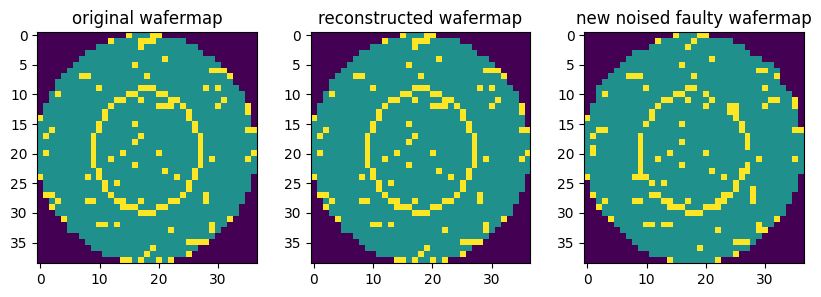

In [ ]:
# check original faulty wafer data
k = 358
print(y_train[k])

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("original wafermap")
plt.imshow(np.argmax(X_train[k], axis=2))

# check reconstructed original faulty wafer data
plt.subplot(1,3,2)
plt.title("reconstructed wafermap")
plt.imshow(gen_X_train[k])

# check new noised faulty wafer data
plt.subplot(1,3,3)
plt.title("new noised faulty wafermap")
plt.imshow(noised_gen_X_train[k])

## Data augmentation
We made convolutional autoencoder model for data augmentation.
We just want the data has 2000 samples for each case. Let's augment data for all faulty case.

In [ ]:
# augment function define
def augment_via_autoencoder(wafer, label, noise_factor=0.5):
    # Encode input wafer
    encoded_X = encoder.predict(wafer, verbose=0)

    # dummy array for collecting noised wafer
    gen_X = np.zeros((1, 39, 37, 3))

    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_X = encoded_X + noise_factor * np.random.normal(size = encoded_X.shape)
        noised_gen_X = decoder.predict(noised_encoded_X, verbose=0)
        gen_X = np.concatenate((gen_X, noised_gen_X), axis=0)

    # also make label vector with same length
    gen_y = np.full(shape=(len(gen_X), 1), fill_value=label)   # create a new array

    # return data without 1st dummy data.
    print(gen_X[1:].shape, gen_y[1:].shape)
    return gen_X[1:], gen_y[1:]

In [ ]:
from tqdm import tqdm

# Augmentation for all faulty case.
new_X_train = X_train.copy()
new_y_train = y_train.copy()

for f in tqdm(faulty_case) :
    # skip none case
    if f == 'none' :
        continue
    gen_X, gen_y = augment_via_autoencoder(X_train[np.where(y_train==f)[0]], f)
    new_X_train = np.concatenate((new_X_train, gen_X), axis=0)
    new_y_train = np.concatenate((new_y_train, gen_y))

 11%|█         | 1/9 [00:03<00:24,  3.08s/it]

(2057, 39, 37, 3) (2057, 1)


 22%|██▏       | 2/9 [00:13<00:51,  7.30s/it]

(2010, 39, 37, 3) (2010, 1)


 33%|███▎      | 3/9 [00:16<00:31,  5.22s/it]

(2317, 39, 37, 3) (2317, 1)


 44%|████▍     | 4/9 [00:29<00:41,  8.33s/it]

(2002, 39, 37, 3) (2002, 1)
(2015, 39, 37, 3) (2015, 1)


 56%|█████▌    | 5/9 [00:32<00:25,  6.36s/it]

(2002, 39, 37, 3) (2002, 1)


 67%|██████▋   | 6/9 [00:45<00:26,  8.69s/it]

(2016, 39, 37, 3) (2016, 1)


 78%|███████▊  | 7/9 [00:52<00:16,  8.23s/it]

(2016, 39, 37, 3) (2016, 1)


100%|██████████| 9/9 [00:57<00:00,  6.40s/it]


In [ ]:
X_train.shape, new_X_train.shape, new_y_train.shape

((7121, 39, 37, 3), (23556, 39, 37, 3), (23556, 1))

In [ ]:
for f in faulty_case :
    print('{:10} : {}'.format(f, len(new_y_train[new_y_train==f])))

Center     : 2178
Donut      : 2025
Edge-Loc   : 2648
Edge-Ring  : 2013
Loc        : 2170
Near-full  : 2013
Random     : 2040
Scratch    : 2058
none       : 6411


In [ ]:
np.where(new_y_train=='none')[0], len(np.where(new_y_train=='none')[0])

(array([   0,    1,    2, ..., 7118, 7119, 7120]), 6411)

- 'none' 타입 웨이퍼 수가 상대적으로 너무 많기 때문에 균형을 이루기 위해 2500 개 정도의 샘플만 취한다.

In [ ]:
# choose indices without replace.

none_idx = np.where(new_y_train=='none')[0]
size = len(none_idx) - 2500   # let's use 2500 samples for 'none' class
none_idx = none_idx[np.random.choice(len(np.where(new_y_train=='none')[0]), size=size, replace=False)]

# delete chosen 'none' class index data
new_X_train = np.delete(new_X_train, none_idx, axis=0)
new_y_train = np.delete(new_y_train, none_idx, axis=0)

In [ ]:
for f in faulty_case :
    print('{:10} : {}'.format(f, len(new_y_train[new_y_train==f])))
print('total size of the (augmented) train data: {}'.format(len(new_y_train)))

Center     : 2178
Donut      : 2025
Edge-Loc   : 2648
Edge-Ring  : 2013
Loc        : 2170
Near-full  : 2013
Random     : 2040
Scratch    : 2058
none       : 2500
total size of the (augmented) train data: 19645


- 이제 각 타입의 웨이퍼가 약 2000~ 2700 정도로 균형을 이루고 있음을 확인하였다.

In [ ]:
new_X_train.shape, new_y_train.shape

((19645, 39, 37, 3), (19645, 1))

In [ ]:
# label encoding and one-hot encoding for the target
# multi-class target names
print(faulty_case)

# for train data
for i, l in enumerate(faulty_case):
    new_y_train[new_y_train==l] = i

# one-hot-encoding
new_y_train_ohe = to_categorical(new_y_train)


['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
# for test data
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i

# one-hot-encoding
y_test_ohe = to_categorical(y_test)

In [ ]:
new_X_train.shape, new_y_train_ohe.shape, X_test.shape, y_test_ohe.shape

((19645, 39, 37, 3), (19645, 9), (3052, 39, 37, 3), (3052, 9))

# 2D CNN Model (ResNet50 전이학습 or Simple 2D CNN)
The data is ready. As wafer data is image. simply use cnn for classification.<br>

In [ ]:
'''
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential, Model

# ResNet50을 사용한 전이 학습 모델 정의
def create_resnet_model(input_shape, num_classes):

    input_tensor = Input(shape=input_shape)

    # Load ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # 학습 가능한 레이어 설정 (상위 레이어를 고정하고 하위 레이어만 학습)
    for layer in base_model.layers[:-10]:  # 마지막 10개의 레이어만 학습 가능하도록 설정
        layer.trainable = False

    # Add your classification layers on top of ResNet50
    x = base_model.output
    x = Flatten()(x)  # Flatten the output of ResNet50
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

# 모델 컴파일 및 학습
input_shape = (39, 37, 3)
num_classes = 9
model = create_resnet_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()
'''

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# 간단한 모델 정의
def classification_model():
    input_tensor = Input(shape=(39, 37, 3))

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dropout_1 = layers.Dropout(0.5)(dense_1)
    dense_2 = layers.Dense(128, activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.5)(dense_2)
    output_tensor = layers.Dense(9, activation='softmax')(dropout_2)

    model = models.Model(input_tensor, output_tensor)

    optimizer = Adam(learning_rate=1e-5)

    model.compile(optimizer = optimizer,
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

    return model

# model creation
model = classification_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 39, 37, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 39, 37, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 39, 37, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 39, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 184704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      94,568,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,719,369 (361.33 MB)

 Trainable params: 94,719,369 (361.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 학습
history = model.fit(new_X_train, new_y_train_ohe,
                    validation_data=[X_test, y_test_ohe],
                    epochs=20,
                    batch_size=128,
                    verbose=2)

Epoch 1/20
154/154 - 26s - 168ms/step - accuracy: 0.3317 - loss: 1.7996 - val_accuracy: 0.7585 - val_loss: 1.6725
Epoch 2/20
154/154 - 10s - 64ms/step - accuracy: 0.5301 - loss: 1.3283 - val_accuracy: 0.5714 - val_loss: 1.4545
Epoch 3/20
154/154 - 10s - 63ms/step - accuracy: 0.6584 - loss: 1.0093 - val_accuracy: 0.6612 - val_loss: 1.2659
Epoch 4/20
154/154 - 10s - 63ms/step - accuracy: 0.7334 - loss: 0.8078 - val_accuracy: 0.7923 - val_loss: 0.9622
Epoch 5/20
154/154 - 10s - 63ms/step - accuracy: 0.7851 - loss: 0.6707 - val_accuracy: 0.8240 - val_loss: 0.7570
Epoch 6/20
154/154 - 10s - 63ms/step - accuracy: 0.8164 - loss: 0.5710 - val_accuracy: 0.7359 - val_loss: 0.8475
Epoch 7/20
154/154 - 10s - 63ms/step - accuracy: 0.8469 - loss: 0.4931 - val_accuracy: 0.8463 - val_loss: 0.5981
Epoch 8/20
154/154 - 10s - 64ms/step - accuracy: 0.8665 - loss: 0.4373 - val_accuracy: 0.8116 - val_loss: 0.6435
Epoch 9/20
154/154 - 10s - 64ms/step - accuracy: 0.8835 - loss: 0.3811 - val_accuracy: 0.8493 -

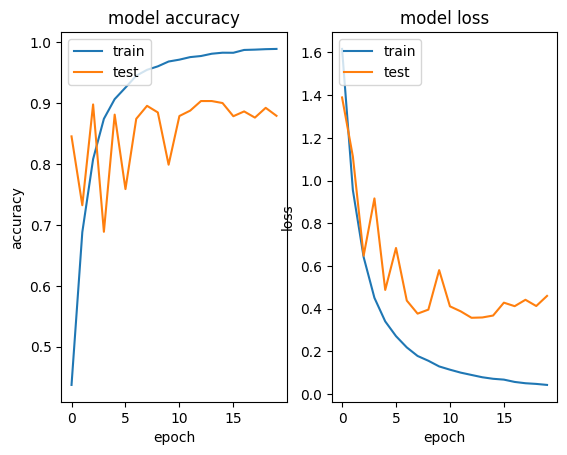

In [ ]:
# accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test_ohe.argmax(axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(cm)
print(classification_report(y_test_classes, y_pred_classes))
print(balanced_accuracy_score(y_test_classes, y_pred_classes))

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[  26    0    0    0    1    0    0    0   25]
 [   0    4    0    0    0    0    1    0    2]
 [   0    0   70    0    3    0    1    0   68]
 [   0    0    4    0    0    0    0    0    0]
 [   3    0    5    0   10    0    2    0   47]
 [   0    0    0    0    0    4    0    0    0]
 [   0    1    0    0    1    1    8    0    0]
 [   0    0    0    0    2    0    0    1   15]
 [  19    0   65    0   31    0    2    2 2628]]
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        52
           1       0.80      0.57      0.67         7
           2       0.49      0.49      0.49       142
           3       0.00      0.00      0.00         4
           4       0.21      0.15      0.17        67
           5       0.80      1.00      0.89         4
           6       0.57      0.73      0.64        11
           7       0.33      0.06      0.10        18
           8       0.94      0.96      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Exerise

# Filtered_version

- now, put filtered version of X_train to the CNN model

In [ ]:
from scipy.ndimage import median_filter

def filtered_map(array, filter_size=2, threshold=1.5):

    # wafer map with 0 = non-interest, 1 = normal, 2 = defect
    array_filtered = median_filter(array, size=filter_size)
    array_filtered = np.where(array_filtered == 0, 0, np.where(array_filtered > threshold, 2, 1))
    return array_filtered


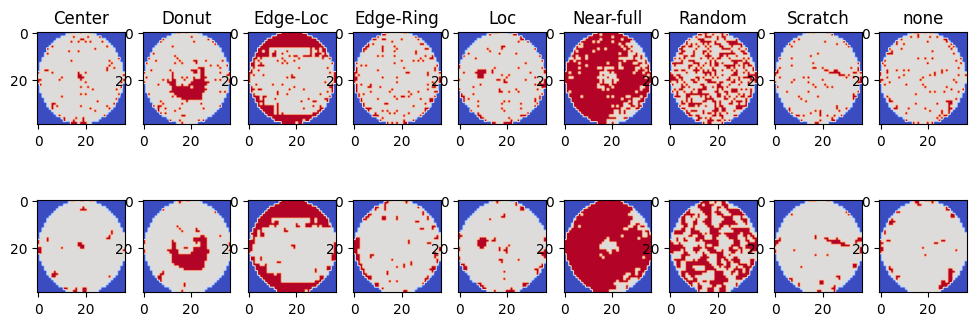

In [ ]:
# plot fault type samples with filtering
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(12,4))
ax = ax.ravel()  # row-major order (C-style)

for i, ftype in enumerate(faulty_case):

    idx = np.where(y_train == ftype)[0][0]  # the first sample for each fault type in train data
    arr = X_train[idx].argmax(axis=2)
    ax[i].set_title(ftype)
    ax[i].imshow(arr, cmap='coolwarm')
    ax[i+9].imshow(filtered_map(arr), cmap='coolwarm')

In [ ]:
new_X_train.shape

(19645, 39, 37, 3)

In [ ]:
new_X_train_decoded = np.argmax(new_X_train, axis=3).reshape(-1, 39, 37, 1)
new_X_train_filtered = to_categorical(filtered_map(new_X_train_decoded))

x_test_decoded = np.argmax(X_test, axis=3).reshape(-1, 39, 37, 1)
X_test_filtered = to_categorical(filtered_map(x_test_decoded))

history = model.fit(new_X_train_filtered, new_y_train_ohe,
         validation_data=[X_test_filtered, y_test_ohe],
         epochs=20,
         batch_size=128,
         verbose=2
         )

Epoch 1/20
154/154 - 2s - 11ms/step - accuracy: 0.8373 - loss: 0.4866 - val_accuracy: 0.0491 - val_loss: 4.2079
Epoch 2/20
154/154 - 1s - 9ms/step - accuracy: 0.8681 - loss: 0.3944 - val_accuracy: 0.5426 - val_loss: 1.2912
Epoch 3/20
154/154 - 1s - 9ms/step - accuracy: 0.8753 - loss: 0.3743 - val_accuracy: 0.3250 - val_loss: 1.5213
Epoch 4/20
154/154 - 1s - 9ms/step - accuracy: 0.8829 - loss: 0.3583 - val_accuracy: 0.5626 - val_loss: 1.3329
Epoch 5/20
154/154 - 1s - 9ms/step - accuracy: 0.8866 - loss: 0.3355 - val_accuracy: 0.5783 - val_loss: 1.0820
Epoch 6/20
154/154 - 1s - 10ms/step - accuracy: 0.8923 - loss: 0.3185 - val_accuracy: 0.1117 - val_loss: 1.6356
Epoch 7/20
154/154 - 1s - 9ms/step - accuracy: 0.8968 - loss: 0.3111 - val_accuracy: 0.0845 - val_loss: 2.4697
Epoch 8/20
154/154 - 1s - 9ms/step - accuracy: 0.8966 - loss: 0.3093 - val_accuracy: 0.0967 - val_loss: 2.2957
Epoch 9/20
154/154 - 1s - 9ms/step - accuracy: 0.9032 - loss: 0.2874 - val_accuracy: 0.5026 - val_loss: 1.2676

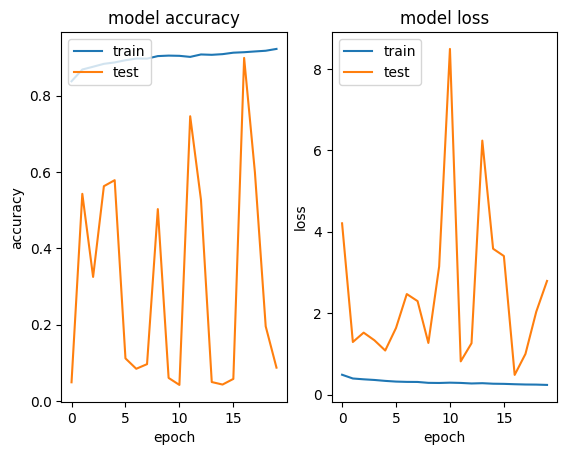

In [ ]:
# accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test_filtered)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test_ohe.argmax(axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(cm)
print(classification_report(y_test_classes, y_pred_classes))
print(balanced_accuracy_score(y_test_classes, y_pred_classes))

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[  22    0    1    0   29    0    0    0    0]
 [   0    4    0    0    3    0    0    0    0]
 [   3    1   73    0   59    0    0    0    6]
 [   0    0    4    0    0    0    0    0    0]
 [   3    1    4    0   58    0    0    1    0]
 [   0    0    0    0    0    1    3    0    0]
 [   0    2    2    0    7    0    0    0    0]
 [   0    1    2    0   15    0    0    0    0]
 [  48    4  214    0 2405    2    3    2   69]]
              precision    recall  f1-score   support

           0       0.29      0.42      0.34        52
           1       0.31      0.57      0.40         7
           2       0.24      0.51      0.33       142
           3       0.00      0.00      0.00         4
           4       0.02      0.87      0.04        67
           5       0.33      0.25      0.29         4
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        18
           8       0.92      0.03      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Filtering 확인

In [ ]:
faulty_case = np.unique(y)
print(f'Faulty case list : {faulty_case}')

for f in faulty_case :
    print('{:10} : {}'.format(f, len(y[y==f])))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
Center     : 173
Donut      : 22
Edge-Loc   : 473
Edge-Ring  : 15
Loc        : 222
Near-full  : 15
Random     : 35
Scratch    : 60
none       : 9158


In [ ]:
y[:5]

array([['Donut'],
       ['Donut'],
       ['Donut'],
       ['Donut'],
       ['Edge-Loc']], dtype='<U9')

In [ ]:
X.shape, filtered_map(X).shape

((10173, 39, 37, 1), (10173, 39, 37, 1))

In [ ]:
for i, ftype in enumerate(faulty_case):
    idx = np.where(y == ftype)
    print(idx[0])
    break

[   48    49    60    62    63    65    66    67   358   465   542   631
   772   816  1265  1475  1676  1768  1906  2228  2286  2421  2439  2468
  2508  2579  2629  2658  2685  2971  3059  3118  3168  3425  3465  3525
  3837  3912  4008  4026  4066  4076  4144  4194  4351  4405  4468  4523
  4541  4554  4560  4674  4709  4909  5019  5416  5424  5442  5697  6004
  6030  6122  6183  6186  6226  6248  6432  6736  6750  6817  6890  6986
  7027  7037  7065  7070  7092  7094  7103  7108  7187  7242  7292  7295
  7311  7323  7341  7353  7450  7464  7508  7530  7590  7593  7652  7660
  7670  7725  7743  7796  7863  7889  7981  8057  8221  8250  8327  8458
  8461  8462  8466  8472  8498  8510  8511  8520  8528  8534  8539  8542
  8565  8570  8575  8603  8625  8628  8669  8672  8673  8684  8694  8696
  8704  8705  8707  8713  8714  8719  8751  8765  8770  8817  8838  8847
  8881  8882  8926  8977  9033  9056  9059  9060  9094  9097  9185  9211
  9234  9258  9263  9274  9306  9330  9340  9344  9

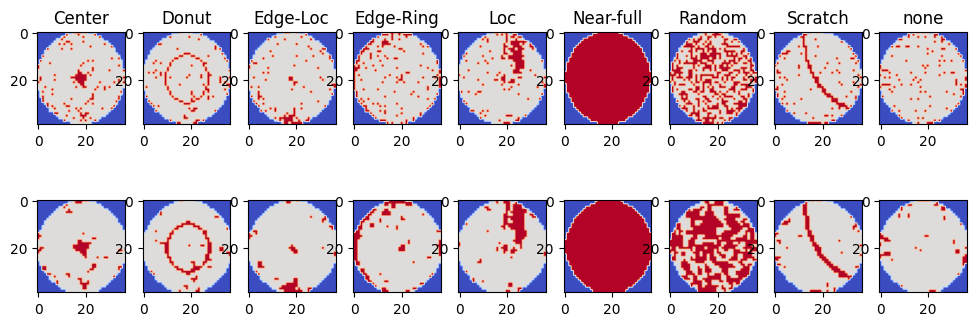

In [ ]:
# plot fault type samples with filtering
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(12,4))
ax = ax.ravel()  # row-major order (C-style)

for i, ftype in enumerate(faulty_case):

    idx = np.where(y == ftype)[0][0]  # the first sample for each fault type
    ax[i].set_title(ftype)
    ax[i].imshow(X[idx], cmap='coolwarm')
    ax[i+9].imshow(filtered_map(X[idx]), cmap='coolwarm')

- size=3으로 필터링을 하게 되면 Donut 타입의 결함이 문제로 보인다. Donut 타입 전체에 대해 size=2 로 해 보자.

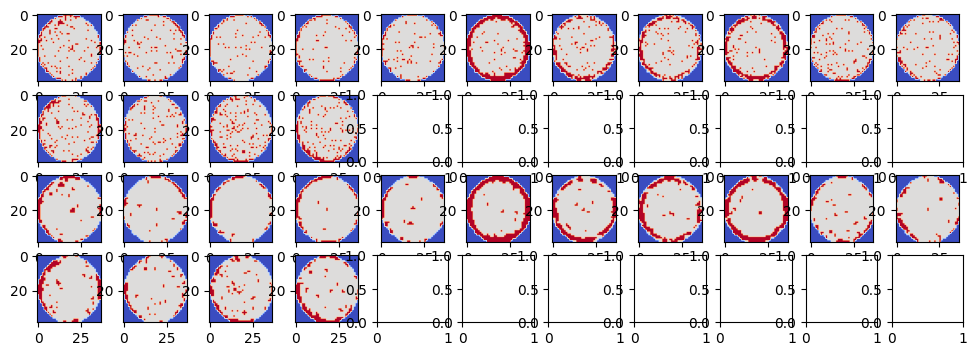

In [ ]:
indices = np.where(y == 'Edge-Ring')[0]

fig, ax = plt.subplots(nrows=4, ncols=11, figsize=(12,4))
ax = ax.ravel()  # row-major order (C-style)

for i, idx in enumerate(indices):
    if i >= 44  or i >= len(indices): break
    ax[i].imshow(X[idx], cmap='coolwarm')
    ax[i+22].imshow(filtered_map (X[idx]), cmap='coolwarm')


In [ ]:
X_filtered = filtered_map(X)

In [ ]:
# One-hot-Encoding faulty categorical variable as channel (no-wafer, normal, faulty)
new_X_filtered = np.zeros((len(X_filtered), 39, 37, 3))

for w in range(len(X_filtered)):
    for i in range(39):
        for j in range(37):
            # new_X[w, i, j, int(X[w, i, j])] = 1
            new_X_filtered[w, i, j, X[w, i, j].astype(int)] = 1

# Dataset created in the original paper
- Wu, Ming-Ju, Jyh-Shing R. Jang, and Jui-Long Chen. “Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets.” IEEE Transactions on Semiconductor Manufacturing 28, no. 1 (February 2015): 1–12.
-  created for wafer map failure pattern recognition (WMFPR)
- WM-811K dataset was built comprising 811 457 wafer
maps, in which each wafer map was collected from real-world fabrication. Domain experts were recruited to annotate the pattern type for approximately 20% of the wafer maps in the WM-811K dataset.
-  TSMC has adopted the proposed system as one of their tools for wafer map analysis, thus confirming the applicability of the proposed features and systems
-


- Typical examples of wafer map failure types

- The WM-811K dataset comprises 811 457 wafer maps that were collected from 46 293 lots in real-world fabrication. Although each lot should contain 25 wafer maps, some were blank (and thus removed) because of sensor failure or for other unknown reasons
- there are only 696 599 unique wafer maps, regardless of their failure bin types (the element of a wafer map is
set at 1 to indicate good dice or 2 to indicate defective dice).
- The data set was divided into a training set (to construct
the recognition system) and a test set (to test the system
performance). For creating the training set, a diverse range
of wafer maps were selected to include each pattern type to
ensure that the constructed model would be robust. Conversely,
the test set comprised wafer maps that were randomly selected
by domain experts.

-  Approximately 20% of the wafer maps were labeled from one of the nine types (54 356 in the training
set and 118 595 in the test set);
- which includes Center, Donut, Edge-local, Edge-ring, Local,
Near-full, Random, Scratch and Nonpattern (the first eight
types are regarded as Pattern)
-  both training and
test sets comprised unique wafer maps.
- Wafer maps are generally accompanied by noise. -> need noise reduction

# Failure pattern recognition results
- 1. identify whether each wafer map exhibited a failure pattern
- 2. identify the wafer map failure pattern after it was classified as a Pattern wafer


# Classical Models

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter, rotate
from collections import Counter
import skimage

# 1. 데이터 로드 및 DataFrame으로 변환
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    X_data = np.array(data['waferMap'])
    y_data = np.array(data['failureType'])

    # DataFrame으로 변환
    df = pd.DataFrame({'waferMap': list(X_data), 'failureType': list(y_data)})

    # 결측값이나 빈 레이블 제거 (레코드 누락 처리)
    df = df.dropna(subset=['waferMap', 'failureType'])

    # 레이블을 해시 가능하고 일관된 값으로 변환
    df['failureType'] = df['failureType'].apply(lambda x: str(x) if not isinstance(x, str) else x)
    # 'failureType'을 숫자형 레이블로 변환
    df['failureType'], unique_labels = pd.factorize(df['failureType'])   # 숫자형 레이블로 변환

    # 숫자 레이블과 원래 값 매핑 정보 출력
    label_mapping = {index: label for index, label in enumerate(unique_labels)}
    print(f'Label mapping: {label_mapping}')

    # Convert the filtered list to a NumPy array
    X_data = np.array(X_data)
    y_data = np.array(df['failureType'])

    return X_data, y_data

# 2. 필터링 적용 함수 (선택 사항)
def apply_median_filter(wafer_map, filter_size=3):
    return median_filter(wafer_map, size=filter_size)

# 3. 회전 및 플립을 사용한 데이터 증강 함수
# 회전 변형은 위치에 관계없이 결함 패턴 자체를 학습하고자 할 때 유용하다.
# 하지만 각 위치(구간)에서 추출한 특징을 사용하여 학습할 때는, 회전으로 인해 특징의 의미가 왜곡될 수 있다.
# 예를 들어, 결함이 특정 위치에 집중되는 패턴이 중요한 경우, 회전된 웨이퍼맵은 모델이 결함 패턴의 위치 특성을
# 잘 학습하지 못하게 할 수 있다.
# CNN(Convolutional Neural Network)**과 같은 이미지 자체를 입력으로 사용하는 경우에는 회전 증강이 더 효과적일 수 있다.

def augment_wafer_map(wafer_map):
    augmented_maps = []
    augmented_maps.append(wafer_map)  # 원본 추가

    # 수평 플립 (좌우 뒤집기)
    augmented_maps.append(np.fliplr(wafer_map))
    # 수직 플립 (상하 뒤집기)
    augmented_maps.append(np.flipud(wafer_map))
    # 3. 수평 + 수직 플립 (대각선 뒤집기)
    augmented_maps.append(np.fliplr(np.flipud(wafer_map)))

    return augmented_maps

# 4. 특징 추출 함수 (9개 구간에 대해)
def extract_features(wafer_map):
    features = []
    split_size_x = wafer_map.shape[0] // 3  # 13
    split_size_y = wafer_map.shape[1] // 3  # 12

    for i in range(3):
        for j in range(3):
            sub_map = wafer_map[i * split_size_x:(i + 1) * split_size_x,
                                j * split_size_y:(j + 1) * split_size_y]
            defect_ratio = np.sum(sub_map == 2) / np.size(sub_map)
            mean_defect = np.mean(sub_map[sub_map == 2]) if np.any(sub_map == 2) else 0
            labeled_map = skimage.measure.label(sub_map == 2)  # 이진 이미지에서 서로 연결된 영역을 구분
            num_clusters = np.max(labeled_map)
            region_props = regionprops(labeled_map)
            cluster_areas = [region.area for region in region_props]
            max_cluster_area = max(cluster_areas) if cluster_areas else 0
            centroid_distances = [np.linalg.norm(np.array(region.centroid) - np.array(sub_map.shape) / 2)
                                  for region in region_props]
            mean_centroid_distance = np.mean(centroid_distances) if centroid_distances else 0
            features.extend([defect_ratio, mean_defect, num_clusters, max_cluster_area, mean_centroid_distance])
    return features

# 5. (39, 37) 크기의 웨이퍼맵 데이터만 추출
def extract_39_37_maps(X_data, y_data):
    X_filtered = []
    y_filtered = []
    for wafer_map, label in zip(X_data, y_data):
        # Check if the wafer map has the correct shape before appending
        if wafer_map.shape == (39, 37):
            X_filtered.append(wafer_map)
            y_filtered.append(label)
    # Convert the filtered lists to NumPy arrays
    # Reshape X_filtered to a 3D array before converting to NumPy array
    X_filtered = np.array(X_filtered).reshape(-1, 39, 37) # Reshape to 3D

    return X_filtered, np.array(y_filtered)


In [ ]:
!ls -l drive/MyDrive/Data/Semicon_Wafer/WM811K.pkl

ls: cannot access 'drive/MyDrive/Data/Semicon_Wafer/WM811K.pkl': No such file or directory


In [ ]:
# 데이터 로드 및 준비
file_path = 'drive/MyDrive/Data/Semicon_Wafer/WM811K.pkl'
X_data, y_data = load_data(file_path)

Label mapping: {0: 'none', 1: 'Loc', 2: '[0 0]', 3: 'Edge-Loc', 4: 'Center', 5: 'Edge-Ring', 6: 'Scratch', 7: 'Random', 8: 'Near-full', 9: 'Donut'}


In [ ]:
X_data.shape, y_data.shape

((811457,), (811457,))

In [ ]:
X_data.shape, y_data.shape, X_data[0].shape, y_data[0]

((811457,), (811457,), (45, 48), 0)

In [ ]:
# (39, 37) 크기의 데이터만 추출
X_data_39_37, y_data_39_37 = extract_39_37_maps(X_data, y_data)

In [ ]:
X_data_39_37.shape, y_data_39_37.shape

((15327, 39, 37), (15327,))

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_data_39_37, y_data_39_37, test_size=0.2, stratify=y_data_39_37, random_state=42)

# 증강된 데이터에서 특징 추출 및 학습 데이터 준비
X_augmented_features = []
y_augmented_labels = []

# 필터링 적용 여부 설정 (True: 적용, False: 미적용)
apply_filter = False

for wafer_map, label_val in zip(X_train, y_train):
    augmented_maps = augment_wafer_map(wafer_map)
    for augmented_map in augmented_maps:
        if apply_filter:  # 필터링 적용 여부 설정
            augmented_map = apply_median_filter(augmented_map)
        features = extract_features(augmented_map)
        X_augmented_features.append(features)
        y_augmented_labels.append(label_val)

# NumPy 배열로 변환
X_augmented_features = np.array(X_augmented_features)
y_augmented_labels = np.array(y_augmented_labels)

In [ ]:
X_augmented_features.shape, y_augmented_labels.shape

((49044, 45), (49044,))

In [ ]:
# Random Forest 모델 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_augmented_features, y_augmented_labels)

# 테스트 데이터에서 특징 추출 및 성능 평가
X_test_features = [extract_features(wafer_map) for wafer_map in X_test]
y_pred = rf_clf.predict(X_test_features)

print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 클래스 비율 확인
print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))

[[1729    1   90   10    2    0    0    0    0    0]
 [  24    3    5    9    2    0    0    0    0    1]
 [ 423    5  592    7    2    0    0    1    0    1]
 [  38    0    2   55    0    0    0    0    0    0]
 [  26    0    2    0    7    0    0    0    0    0]
 [   2    0    0    1    0    0    0    0    0    0]
 [  10    0    0    1    0    0    1    0    0    0]
 [   0    1    0    0    0    0    0    5    1    0]
 [   0    0    0    0    0    0    0    0    3    0]
 [   0    0    1    0    0    0    0    2    0    1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1832
           1       0.30      0.07      0.11        44
           2       0.86      0.57      0.69      1031
           3       0.66      0.58      0.62        95
           4       0.54      0.20      0.29        35
           5       0.00      0.00      0.00         3
           6       1.00      0.08      0.15        12
           7 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 데이터 분할 (학습용/테스트용)
X_train, X_test, y_train, y_test = train_test_split(X_data_39_37, y_data_39_37, test_size=0.2, stratify=y_data_39_37, random_state=42)

# 특성 추출 (이전 코드의 extract_features 사용)
X_train_features = [extract_features(wafer_map) for wafer_map in X_train]
X_test_features = [extract_features(wafer_map) for wafer_map in X_test]

# 1. 증강 방법을 선택할 수 있는 함수 정의
def balanced_augmentation(X_train_features, y_train, method='flipping', target_ratio=0.5):
    """
    선택된 증강 방법을 사용하여 소수 클래스에 대해 증강을 수행하는 함수.

    Parameters:
        X_train_features: list - 특성 벡터로 변환된 훈련 데이터.
        y_train: list - 훈련 데이터의 레이블.
        method: str - 사용하려는 증강 방법 ('flipping', 'smote', 'adasyn').
        target_ratio: float - 소수 클래스 증강 목표 비율 (대다수 클래스의 비율 기준).

    Returns:
        X_resampled: np.array - 증강된 특성 데이터.
        y_resampled: np.array - 증강된 레이블 데이터.
    """
    print(f"Applying {method} to minority classes only")
    class_counts = Counter(y_train)
    majority_class = max(class_counts, key=class_counts.get)
    majority_count = class_counts[majority_class]

    # 목표 샘플 수 설정 (대다수 클래스의 50% ~ 75%)
    target_counts = {cls: int(majority_count * target_ratio) for cls in class_counts if cls != majority_class}

    # 소수 클래스에 대해서만 증강 수행
    X_resampled, y_resampled = [], []
    for cls in class_counts:
        if cls == majority_class:
            # 대다수 클래스는 그대로 추가
            X_resampled.extend([x for x, y in zip(X_train_features, y_train) if y == cls])
            y_resampled.extend([y for y in y_train if y == cls])
        else:
            # Check if the class has more than one unique value
            y_cls_values = [y for y in y_train if y == cls]
            if len(np.unique(y_cls_values)) <= 1:
                print(f"Skipping oversampling for class {cls} as it has only one unique value.")
                # Add the original data for this class without oversampling
                X_resampled.extend([x for x, y in zip(X_train_features, y_train) if y == cls])
                y_resampled.extend(y_cls_values)
                continue

            # 소수 클래스 증강 방법 선택
            if method == 'smote':
                smote = SMOTE(sampling_strategy={cls: target_counts[cls]}, random_state=42)
                X_cls, y_cls = smote.fit_resample(
                    [x for x, y in zip(X_train_features, y_train) if y == cls],
                    [y for y in y_train if y == cls]
                )
            elif method == 'adasyn':
                adasyn = ADASYN(sampling_strategy={cls: target_counts[cls]}, random_state=42)
                X_cls, y_cls = adasyn.fit_resample(
                    [x for x, y in zip(X_train_features, y_train) if y == cls],
                    [y for y in y_train if y == cls]
                )
            elif method == 'flipping':
                # 플리핑 증강 적용 (여기서는 간단히 플리핑으로 2배 증강)
                X_cls = [x for x, y in zip(X_train_features, y_train) if y == cls]
                X_flipped = [np.flip(x) for x in X_cls]  # 데이터를 뒤집어서 증강
                X_cls.extend(X_flipped)
                y_cls = [cls] * len(X_cls)
            else:
                raise ValueError(f"Unknown augmentation method: {method}")

            # 증강된 데이터 추가
            X_resampled.extend(X_cls)
            y_resampled.extend(y_cls)

    print(f"After {method}, training class distribution:", Counter(y_resampled))
    return np.array(X_resampled), np.array(y_resampled)

# 2. 모델 학습 함수
def train_model(X_train_features, y_train, X_test_features, y_test):
    # Random Forest 모델 학습
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_features, y_train)

    # 예측 및 성능 평가
    y_pred = rf_clf.predict(X_test_features)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return rf_clf

# 증강 방법 설정 (예: 'flipping', 'smote', 'adasyn')
augmentation_method = 'adasyn'  # 사용할 증강 방법 선택
target_ratio = 0.6  # 소수 클래스 증강 비율 설정

# 선택된 증강 방법으로 데이터 증강
X_resampled, y_resampled = balanced_augmentation(X_train_features, y_train, method=augmentation_method, target_ratio=target_ratio)

# 모델 학습 및 성능 평가
rf_clf = train_model(X_resampled, y_resampled, X_test_features, y_test)


Applying adasyn to minority classes only
Skipping oversampling for class 2 as it has only one unique value.
Skipping oversampling for class 1 as it has only one unique value.
Skipping oversampling for class 3 as it has only one unique value.
Skipping oversampling for class 4 as it has only one unique value.
Skipping oversampling for class 9 as it has only one unique value.
Skipping oversampling for class 7 as it has only one unique value.
Skipping oversampling for class 6 as it has only one unique value.
Skipping oversampling for class 8 as it has only one unique value.
Skipping oversampling for class 5 as it has only one unique value.
After adasyn, training class distribution: Counter({0: 7326, 2: 4123, 3: 378, 1: 178, 4: 138, 6: 48, 7: 28, 9: 18, 8: 12, 5: 12})
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1832
           1       0.29      0.05      0.08        44
           2       0.85      0.59      0

In [ ]:
y_pred = rf_clf.predict(X_test_features)
print(confusion_matrix(y_test, y_pred))

[[1733    0   91    6    2    0    0    0    0    0]
 [  27    2    9    4    2    0    0    0    0    0]
 [ 406    4  612    7    1    0    0    0    0    1]
 [  43    0    5   46    0    1    0    0    0    0]
 [  27    0    2    0    6    0    0    0    0    0]
 [   2    0    0    1    0    0    0    0    0    0]
 [   9    0    0    2    0    0    1    0    0    0]
 [   1    1    0    0    0    0    0    5    0    0]
 [   0    0    0    0    0    0    0    1    2    0]
 [   0    0    1    0    0    0    0    2    0    1]]
